In [1]:
# Realized σ vs EWMA σ: realized uses a fixed window and treats each day equally; 
#EWMA down-weights older shocks, adapting faster to regime shifts.

# Finite-window EWMA: a “local” view—weights normalized within the last n days 
#only; useful for near-term forecasts (rolling forward section).


#VaR/ES:
#Historical: model-free, uses your own tail—good when distributions are non-Normal.
#Normal-EWMA: tractable & responsive via λ, but can understate fat tails.
#ES complements VaR by averaging the size of tail losses, not just the cutoff.


#Backtests:
#Kupiec checks if the rate of breaches matches the target (e.g., ~5% for 95%).
#Christoffersen checks for clustering (independence); a good model shouldn’t produce streaky exceptions.

In [2]:
import sys, pathlib; sys.path.append(str(pathlib.Path.cwd() / "src"))
from pathlib import Path
import numpy as np, pandas as pd

In [3]:
# --- Make local package importable (robust for notebooks in subfolders) ---
def add_src_to_path(pkg="quantlib", levels_up=3):
    here = Path.cwd().resolve()
    candidates = [here / "src"]
    # also check parents: ../src, ../../src, ...
    for i in range(1, levels_up+1):
        candidates.append(here.parents[i-1] / "src")
    for p in candidates:
        if (p / pkg / "__init__.py").exists():
            sys.path.insert(0, str(p))
            print(f"[OK] Added to sys.path: {p}")
            return p
    raise FileNotFoundError("Could not find src/quantlib/__init__.py relative to this notebook.")

add_src_to_path()


[OK] Added to sys.path: C:\Users\quantbase\Desktop\quant\src


WindowsPath('C:/Users/quantbase/Desktop/quant/src')

In [4]:
# --- bootstrap & imports ---
import sys, pathlib; sys.path.append(str(pathlib.Path.cwd() / "src"))
from pathlib import Path
import pandas as pd
import numpy as np
from quantlib import risk as qrisk
import importlib, quantlib.viz as qviz

#DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
#FIG_DIR = Path(r"C:\Users\quantbase\Desktop\quant\figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)


qrisk = importlib.reload(qrisk)
qviz = importlib.reload(qviz)


In [5]:

#from pathlib import Path

def get_index_name(int_dir: Path, panel_cols) -> str:
    """Try meta file, else regex heuristic among panel columns."""
    meta = int_dir / "index_meta.txt"
    if meta.exists():
        txt = meta.read_text(encoding="utf-8").strip()
        if txt and txt in panel_cols:
            return txt
    # Heuristic: look for NIFTY* / BANKNIFTY* etc.
    import re
    pats = [r'^NIFTY\d*$', r'^BANKNIFTY\d*$', r'^NIFTYBANK$', r'^NIFTY500$', r'^NIFTYMIDCAP\d*$']
    for c in panel_cols:
        up = str(c).upper().replace(" ", "")
        if any(re.match(p, up) for p in pats):
            return c
    return ""


In [6]:
ROOT = Path(r"C:\Users\quantbase\Desktop\quant")
RUN_DATE = "30-09-2025"  # <- set this for the run you want to analyze
RUN_DIR  = ROOT / RUN_DATE
DATA_INT = RUN_DIR / "data_int"
FIG_DIR = RUN_DIR/ "figures"

In [7]:
# --- load portfolio returns ---
r_port = pd.read_pickle(DATA_INT/"portfolio_returns.pkl").sort_index()

In [8]:
# BACKTEST----------------------------------

In [9]:
# --- Historical VaR/ES (252d, 95%) & Normal-EWMA VaR/ES (λ=0.94) ---
hist_63_95 = qrisk.hist_var_es(r_port, window=63, alpha=0.95)
norm_ewma_95 = qrisk.normal_ewma_var_es(r_port, lam=0.94, alpha=0.95)


In [10]:
# --- Backtest exceptions + p-values (Kupiec & Christoffersen) ---
exc = qrisk.var_exceptions(r_port, hist_63_95["VaR"])
p_uc, s_uc   = qrisk.kupiec_pvalue(exc, alpha=0.95)
p_ind, s_ind = qrisk.christoffersen_pvalue(exc)
traffic = qrisk.traffic_light(p_uc, p_ind)

In [11]:
print("Kupiec:", s_uc, "p=", p_uc)
print("Christoffersen:", s_ind, "p=", p_ind)
print("Traffic:", traffic)


Kupiec: {'T': 1199, 'N': 77, 'LR_uc': 4.701857116709767, 'phat': 0.06422018348623854, 'p': 0.050000000000000044} p= 0.03013004394574481
Christoffersen: {'LR_ind': 8.629729017752302, 'N00': 1056, 'N01': 65, 'N10': 65, 'N11': 12, 'pi0': 0.05798394290811775, 'pi1': 0.15584415584415584, 'pi': 0.0642737896494157} p= 0.003307207664084877
Traffic: RED


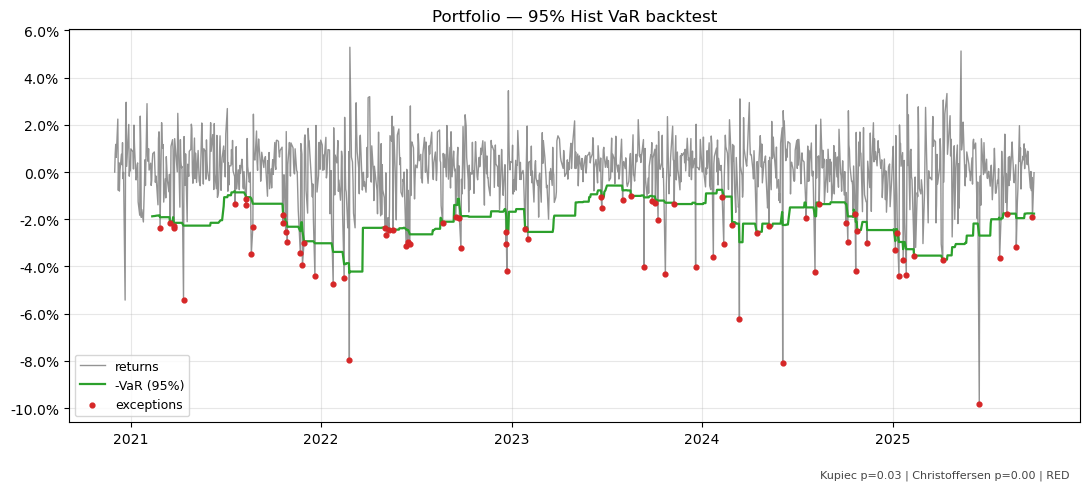

In [12]:
# --- Visual backtest ---
foot = f"Kupiec p={p_uc:.2f} | Christoffersen p={p_ind:.2f} | {traffic}"
qviz.plot_var_exceptions(r_port, hist_63_95['VaR'], title="Portfolio — 95% Hist VaR backtest", alpha_label="95%", footnote=foot, save_path=FIG_DIR/"var_hist_95.png")


In [13]:
#hist_63_95 = qrisk.hist_var_es(r_p, window=63, alpha=0.95)
#(hist_63_95)

In [14]:
hist_21_95 = qrisk.hist_var_es(r_port, window=21, alpha=0.95)
hist_21_95

,VaR,ES
2020-12-01,NaN,NaN
2020-12-02,NaN,NaN
2020-12-03,NaN,NaN
2020-12-04,NaN,NaN
2020-12-07,NaN,NaN
...,...,...
2025-09-23,0.012862,0.022356
2025-09-24,0.012862,0.022356
2025-09-25,0.007834,0.010348
2025-09-26,0.007834,0.013454


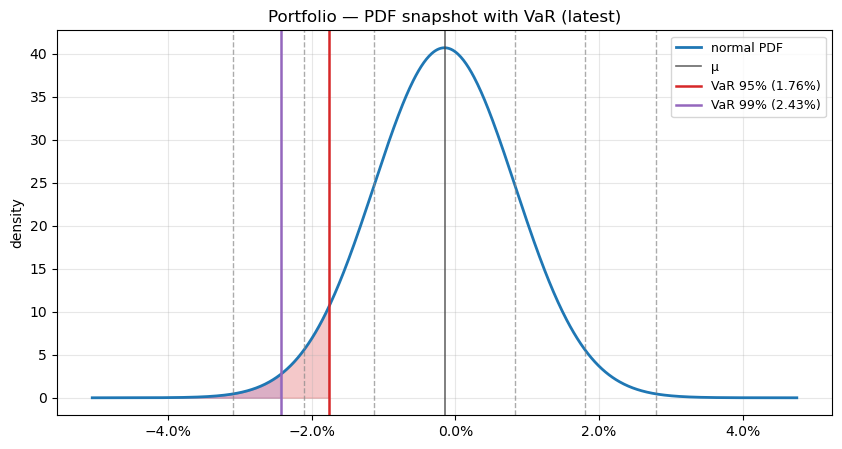

In [15]:
# Load portfolio returns (or pick a symbol)
r_port = pd.read_pickle(DATA_INT/"portfolio_returns.pkl").sort_index()

# Choose estimator for today's σ (examples)
sigma_today = qrisk.ewma_var_recursive(r_port, lam=0.94).pow(0.5).iloc[-1]     # EWMA(0.94)
# or: sigma_today = qrisk.realized_vol(r_port, 252).iloc[-1]                   # 1Y realized

# drift (use 0 or small rolling mean)
mu_today = r_port.rolling(63).mean().iloc[-1]
if not np.isfinite(mu_today): mu_today = 0.0

# Plot snapshot PDF with 95% & 99% VaR shading + ±1/2/3σ lines
qviz.plot_var_pdf_snapshot(
    mu=float(mu_today),
    sigma=float(sigma_today),
    alphas=(0.95, 0.99),
    dist="normal",
    title="Portfolio — PDF snapshot with VaR (latest)",
    save_path=FIG_DIR/"var_snapshot_normal.png"
)


In [18]:
# choose in ONE place:
VOL_MODEL = "garch11"   # options: "ewma", "garch11", "arch"
LAMBDA    = 0.94        # used if VOL_MODEL == "ewma"
EWMA_WIN  = 21
H_FUTURE  = 200          # forward business days for VaR term structure


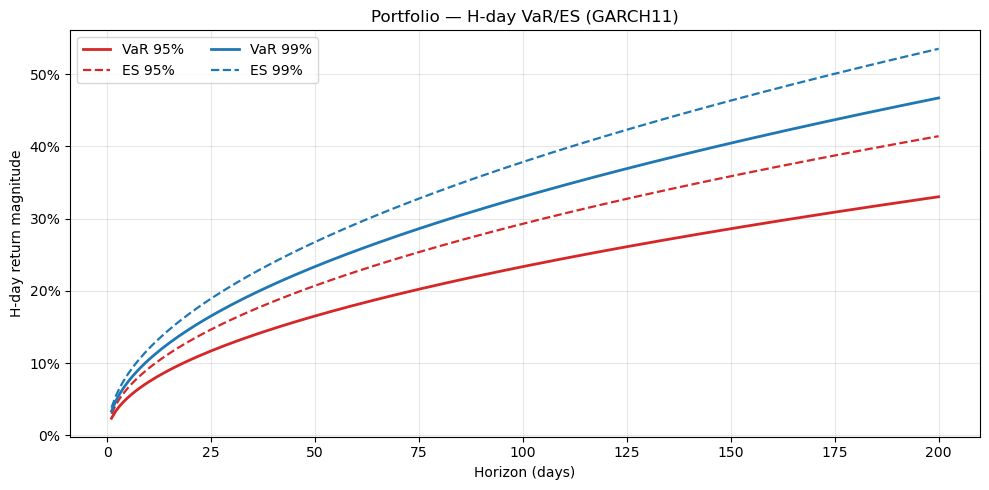

In [19]:
# pick target series: portfolio or a symbol
r_port = pd.read_pickle(DATA_INT/"portfolio_returns.pkl").sort_index()

# forward σ via the toggle
sig_fwd = qrisk.vol_forecast_path(
    r_port,
    model=VOL_MODEL,
    horizon=H_FUTURE,
    lam=LAMBDA,
    ewma_window=EWMA_WIN,
)

# H-day VaR/ES curves (Normal)
curves = qrisk.horizon_var_es_from_forward_sigma(
    sig_fwd, alphas=(0.95, 0.99), dist="normal", H_max=H_FUTURE
)

qviz.plot_var_es_horizon_curves(
    curves,
    alphas=(0.95, 0.99),
    title=f"Portfolio — H-day VaR/ES ({VOL_MODEL.upper()})",
    save_path=FIG_DIR/f"var_es_horizon_{VOL_MODEL}.png"
)
